In [1]:
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import random

## Read all lines from csv

In [2]:
lines = []
dir = './data/IMG/'

with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for line in reader:
        lines.append(line)

## Read Images and Measurement
Includes left and right camera images and measurement

In [3]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

images = []
image_flipped = []
measurements = []
measurement_flipped = []

for line in lines: 
    for col in range(3):
        source_path = line[col]
        filename = source_path.split('/')[-1]
        current_path = dir + filename
        image = cv2.imread(current_path)
        images.append(image)
        image_flipped.append(np.fliplr(image))

    measurement = float(line[3])
    measurements.append(measurement)
    measurements.append(measurement+0.2)
    measurements.append(measurement-0.2)

print("Total Images: ", len(images)," | Total Measurements: ",len(measurements))

Total Images:  30768  | Total Measurements:  30768


## Data Augmentation
Not required for this case

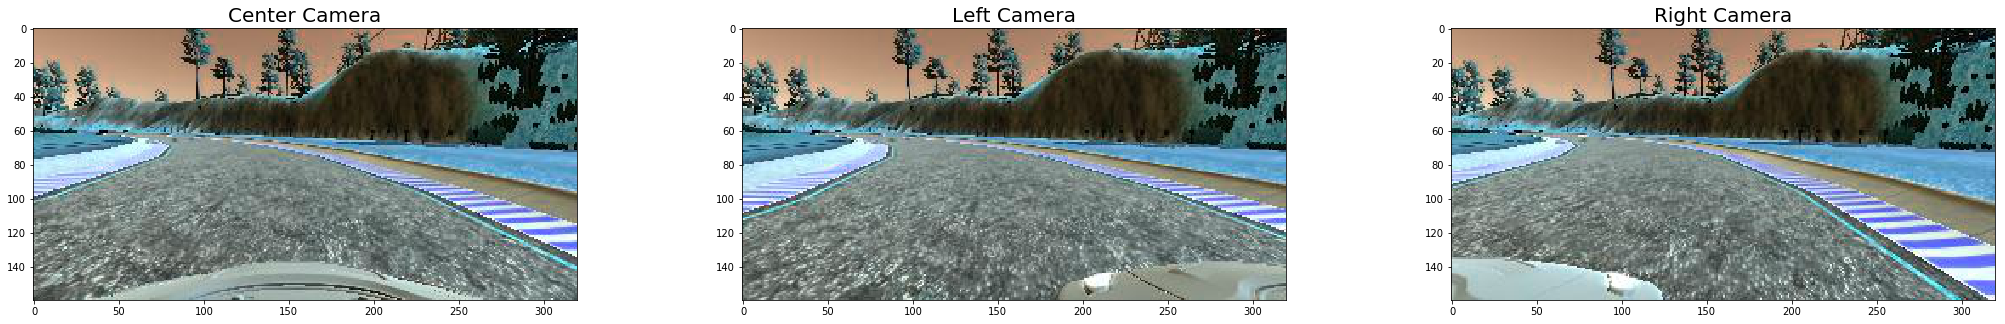

In [4]:
aug_images = images + image_flipped
measurement_flipped = [-1*x for x in measurements]
aug_measurements = measurements + measurement_flipped

f, ax = plt.subplots(1,3, figsize=(36,5))
ax[0].imshow(images[0])
ax[0].set_title('Center Camera', fontsize=20)

ax[1].imshow(images[1])
ax[1].set_title('Left Camera', fontsize=20)

ax[2].imshow(images[2])
ax[2].set_title('Right Camera', fontsize=20)

f.savefig("./examples/camera_angles.png")
plt.show()

## Visualizing Raw Data
Historgram of measurement bins

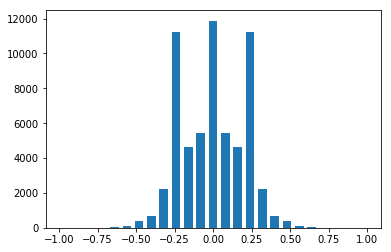

Mean of Measurement:  2461.44


In [5]:
nbin = 25
hist, bins = np.histogram(aug_measurements, nbin)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.savefig("./examples/old_hist.png")
plt.show()
avg_value = np.mean(hist)
print("Mean of Measurement: ", avg_value)

## Resample Data to the mean

In [6]:
keep_prob = []
for i in range(nbin):
    if hist[i] <= avg_value:
        keep_prob.append(1)
    else:
        keep_prob.append(avg_value/hist[i])

remove_ind = []
for i in range(len(aug_measurements)):
    for j in range(nbin):
        if aug_measurements[i] > bins[j] and aug_measurements[i] <= bins[j+1]:
            if random.random() < (1-keep_prob[j]):
                remove_ind.append(i)

# keep_probs = []
# target = avg_value * .5
# for i in range(nbin):
#     if hist[i] < target:
#         keep_probs.append(1.)
#     else:
#         keep_probs.append(1./(hist[i]/target))
# remove_list = []
# for i in range(len(aug_measurements)):
#     for j in range(nbin):
#         if aug_measurements[i] > bins[j] and aug_measurements[i] <= bins[j+1]:
#             # delete from X and y with probability 1 - keep_probs[j]
#             if np.random.rand() > keep_probs[j]:
#                 remove_list.append(i)
                
new_images = np.delete(aug_images, remove_ind, 0)
new_measurements = np.delete(aug_measurements, remove_ind, 0)

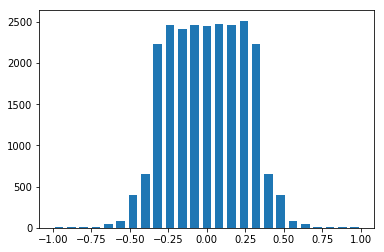

In [7]:
# nbin = 25
hist, bins = np.histogram(new_measurements, nbin)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.savefig("./examples/new_hist.png")
plt.show()
avg_value = np.mean(hist)

In [8]:
X_train = np.array(new_images)
y_train = np.array(new_measurements)

## Train Model

In [9]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,Lambda, Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

model = Sequential()
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Convolution2D(24, 5, 5,subsample=(2,2), activation="relu"))
# model.add(MaxPooling2D())
model.add(Convolution2D(36, 5, 5,subsample=(2,2), activation="relu"))
# model.add(MaxPooling2D())
model.add(Convolution2D(48, 5, 5,subsample=(2,2), activation="relu"))
# model.add(MaxPooling2D())
# model.add(Dropout(0.5))
model.add(Convolution2D(64, 3, 3, activation="relu"))
# model.add(MaxPooling2D())
model.add(Convolution2D(100, 3, 3, activation="relu"))
# model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(100, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(50, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=1e-4))
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5)


Using TensorFlow backend.
/home/nitish/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  if __name__ == '__main__':
/home/nitish/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  # This is added back by InteractiveShellApp.init_path()
/home/nitish/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  del sys.path[0]
/home/nitish/anaconda3/envs/IntroToTensorFlow/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  app.launch_new_instance(

Train on 19330 samples, validate on 4833 samples
Epoch 1/5
19330/19330 [==============================] - 14s - loss: 0.0234 - val_loss: 0.0242
Epoch 2/5
19330/19330 [==============================] - 13s - loss: 0.0156 - val_loss: 0.0229
Epoch 3/5
19330/19330 [==============================] - 13s - loss: 0.0141 - val_loss: 0.0218
Epoch 4/5
19330/19330 [==============================] - 13s - loss: 0.0129 - val_loss: 0.0215
Epoch 5/5
19330/19330 [==============================] - 13s - loss: 0.0122 - val_loss: 0.0209


In [10]:
## Save h5
model.save('model.h5')
print("Model Saved!")

Model Saved!
